# Random Forest based MMM 

## Motivation and background context


Historically, MMM models have primarily relied on Generalized Linear Models (GLMs) with regularization techniques. While GLMs offer a degree of interpretability, they often face challenges such as multicollinearity and the assumption of a linear relationship between predictors and the outcome. To address these issues, MMM practitioners typically employ data transformations like Adstock (carryover effect), Saturation (diminishing returns) and use log-linear functional form. However, these fixes require significantly additional work to interpret model results, particularly when decomposing the impact of individual media channels on the KPI of interest.

My goal in this project is to explore the potential of Random Forest as an alternative to GLMs for MMM. Random Forest is a machine learning algorithm that excels at handling multicollinearity and capturing non-linear relationships. Secondly, I want to separate out the problem of interpretability and apply newer techniques like SHAP to explain & interpret the model results. By leveraging capabilities of Random Forest and explaining the results using SHAP, I aim to simplify model building and improve interpretability without sacrificing predictive accuracy

Here's a breakdown of how the Random Forest process works:

1. *Bootstrap Aggregation (Bagging):* - Multiple Samples: The algorithm creates multiple bootstrap samples from the original dataset. Each sample is created by randomly selecting rows with replacement.
Decision Trees: A decision tree is built on each bootstrap sample.

2. *Feature Randomization:* - Subset of Features: At each node of a decision tree, only a random subset of features is considered for splitting. This helps to reduce the correlation between trees and improve generalization.

3. *Voting:* - Prediction: Each decision tree makes a prediction for a given input.
Majority Vote: The final prediction is made by taking a majority vote of the predictions from all the trees.

#### Advantages of Random Forest over Generalized Linear Models (GLMs)

- *Handling Non-Linear Relationships:* Random Forest can capture complex non-linear relationships between features and the target variable, while GLMs are typically limited to linear relationships.   
- *Robustness to Outliers:* Random Forest is less sensitive to outliers than GLMs, as the ensemble nature of the algorithm helps to reduce the impact of individual data points.
- *Feature Importance:* Random Forest provides a measure of feature importance, which can be helpful for understanding the relative contributions of different features to the prediction.
- *Automatic Feature Selection:* Random Forest can automatically select the most important features, reducing the need for manual feature engineering.
- *Handling Missing Data:* Random Forest can handle missing data without imputation, as the algorithm can still make predictions based on the information from the other features.

#### Model Interpretation using SHAP values

**SHAP Values: A Primer** 

SHAP (SHapley Additive exPlanations) values are a game-theoretic approach to explain the output of any machine learning model. They provide a way to quantify the contribution of each feature to a prediction.   

**How SHAP Values Work:**

1. *Consider the Model as a Game:* SHAP views the model as a cooperative game where the features are players. Each feature's contribution to the prediction is determined based on its marginal impact on the outcome when combined with different subsets of other features.
2. *Calculate Shapley Values:* Using a concept from game theory called the Shapley value, SHAP calculates the average marginal contribution of each feature across all possible combinations of other features.
3. *Interpret the Results:* The SHAP values can be visualized in various ways, such as:
> 3a. SHAP Summary Plots: These plots show the average SHAP values for each feature, sorted by their importance.
> 
> 3b. SHAP Dependence Plots: These plots show how the impact of a feature on the prediction varies depending on the values of other features.
> 
> 3c. Force Plots: These plots visualize the contributions of individual features to a specific prediction, showing how they push the prediction towards its final value.

**Using SHAP Values for Model Interpretation:**

* *Feature Importance:* SHAP values can help identify the most important features in a model, providing insights into which factors are driving the predictions.
* *Understanding Individual Predictions:* By examining the SHAP values for a specific prediction, you can understand how different features contributed to that outcome.
* *Detecting Interactions:* SHAP dependence plots can reveal interactions between features, helping to identify complex relationships that might not be apparent from simple correlation analysis.
* *Debugging Models:* SHAP values can help identify potential issues in a model, such as overfitting or bias.

**Advantages of SHAP Values:**

* *Model-Agnostic:* SHAP values can be applied to any machine learning model, regardless of its complexity or type.
Interpretability: SHAP provides a clear and understandable explanation of feature contributions to predictions.
* *Global and Local Explanations:* SHAP can provide both global (average feature importance) and local (explanation of individual predictions) explanations.

By using SHAP values, you can gain valuable insights into your machine learning models, improve their interpretability, and build more trustworthy and reliable predictive systems.

## Install Requirements

<div class="alert alert-block alert-info">
<b>Note:</b> You may need to restart the kernel after installing the requirements.</div>

In [839]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Import Requirements

In [755]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [819]:
import math
import sys
import os
import warnings

import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import json

pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.4f}'.format}, linewidth=130)

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

from prophet import Prophet
from functools import partial
import optuna as opt
import shap
shap.initjs()

import RF_MMM_utils
from RF_MMM_utils import *

## Import Data

In [13]:
df = pd.read_csv("./data/dt_simulated_weekly.csv", parse_dates = [0])

In [15]:
df.head()

week      revenue       tv_S       ooh_S    print_S    facebook_I  \
0 2015-11-23 2754371.6670 22358.3467      0.0000 12728.4889 24301284.2400   
1 2015-11-30 2584276.6670 28613.4533      0.0000     0.0000  5527033.1820   
2 2015-12-07 2547386.6670     0.0000 132278.4000   453.8667 16651591.2200   
3 2015-12-14 2875220.0000 83450.3067      0.0000 17680.0000 10549765.6800   
4 2015-12-21 2215953.3330     0.0000 277336.0000     0.0000  2934089.8260   

   search_clicks_P  search_S  competitor_sales_B  facebook_S events  \
0           0.0000    0.0000             8125009   7607.1329     na   
1        9837.2385 4133.3333             7901549   1141.9524     na   
2       12044.1197 3786.6667             8300197   4256.3754     na   
3       12268.0703 4253.3333             8122883   2800.4907     na   
4        9467.2480 3613.3333             7105985    689.5826     na   

   newsletter  
0  19401.6538  
1  14791.0000  
2  14544.0000  
3   2800.0000  
4  15478.0000

In [17]:
# Find out which day of the week, the week column corresponds to
df.week.dt.day_name().value_counts()

week
Monday    208
Name: count, dtype: int64

In [19]:
# Identify the start week and end week in the data
print(f'Start week in data is: {df.week.min()}')
print(f'End week in data is: {df.week.max()}')

Start week in data is: 2015-11-23 00:00:00
End week in data is: 2019-11-11 00:00:00


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   week                208 non-null    datetime64[ns]
 1   revenue             208 non-null    float64       
 2   tv_S                208 non-null    float64       
 3   ooh_S               208 non-null    float64       
 4   print_S             208 non-null    float64       
 5   facebook_I          208 non-null    float64       
 6   search_clicks_P     208 non-null    float64       
 7   search_S            208 non-null    float64       
 8   competitor_sales_B  208 non-null    int64         
 9   facebook_S          208 non-null    float64       
 10  events              208 non-null    object        
 11  newsletter          208 non-null    float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(1)
memory usage: 19.6+ KB


In [23]:
df_model = df.copy()
# Perform one-hot encoding
df_model = pd.concat([df_model.drop('events', axis=1), pd.get_dummies(df_model["events"], prefix = "events")], axis = 1)
df_model = df_model.drop('events_na', axis=1).rename(columns = {'week': 'ds', 'revenue':'y'})
df_model.head()

ds            y       tv_S       ooh_S    print_S    facebook_I  \
0 2015-11-23 2754371.6670 22358.3467      0.0000 12728.4889 24301284.2400   
1 2015-11-30 2584276.6670 28613.4533      0.0000     0.0000  5527033.1820   
2 2015-12-07 2547386.6670     0.0000 132278.4000   453.8667 16651591.2200   
3 2015-12-14 2875220.0000 83450.3067      0.0000 17680.0000 10549765.6800   
4 2015-12-21 2215953.3330     0.0000 277336.0000     0.0000  2934089.8260   

   search_clicks_P  search_S  competitor_sales_B  facebook_S  newsletter  \
0           0.0000    0.0000             8125009   7607.1329  19401.6538   
1        9837.2385 4133.3333             7901549   1141.9524  14791.0000   
2       12044.1197 3786.6667             8300197   4256.3754  14544.0000   
3       12268.0703 4253.3333             8122883   2800.4907   2800.0000   
4        9467.2480 3613.3333             7105985    689.5826  15478.0000   

   events_event1  events_event2  
0          False          False  
1          False          False  
2          False          False  
3          False          False  
4          False          False

In [25]:
holidays = pd.read_csv("./data/dt_prophet_holidays.csv", parse_dates = [0])
holidays["ds"] = holidays["ds"].dt.to_period('W').dt.to_timestamp()
holidays = holidays[(holidays.country == 'US') & (holidays.year.between(2015, 2019, inclusive = 'both'))].copy()
holidays_weekly = holidays.groupby(["ds", "country", "year"], as_index = False).agg({'holiday':'|'.join, 'country': 'first', 'year': 'first'})
holidays_weekly.head()

ds                                       holiday country  year
0 2014-12-29                                New Year's Day      US  2015
1 2015-01-19                    Martin Luther King Jr. Day      US  2015
2 2015-02-16                         Washington's Birthday      US  2015
3 2015-05-25                                  Memorial Day      US  2015
4 2015-06-29  Independence Day (Observed)|Independence Day      US  2015

In [27]:
# Find out which day of the week, the week column corresponds to
holidays_weekly.ds.dt.day_name().value_counts()

ds
Monday    53
Name: count, dtype: int64

In [29]:
# Identify the start week and end week in the data
print(f'Start week in data is: {holidays_weekly.ds.min()}')
print(f'End week in data is: {holidays_weekly.ds.max()}')

Start week in data is: 2014-12-29 00:00:00
End week in data is: 2019-12-23 00:00:00


**Observations**
* We have 208 weeks of data
* `revenue` is our target variable
* `tv_S`, `ooh_S`, `print_S`, `faebook_S` and `search_S` are media spend variables for different media channels
* `facebook_I` is a media exposure (Impressions) variable 
* `search_clicks_P` is a media activity (clicks) variable
* `newsletter` is organic media variable without spend
* Control variables - `events`, `competitor_sales_B`
* No null or missing values in any of the columns

## Get trend and seasonality terms using Prophet

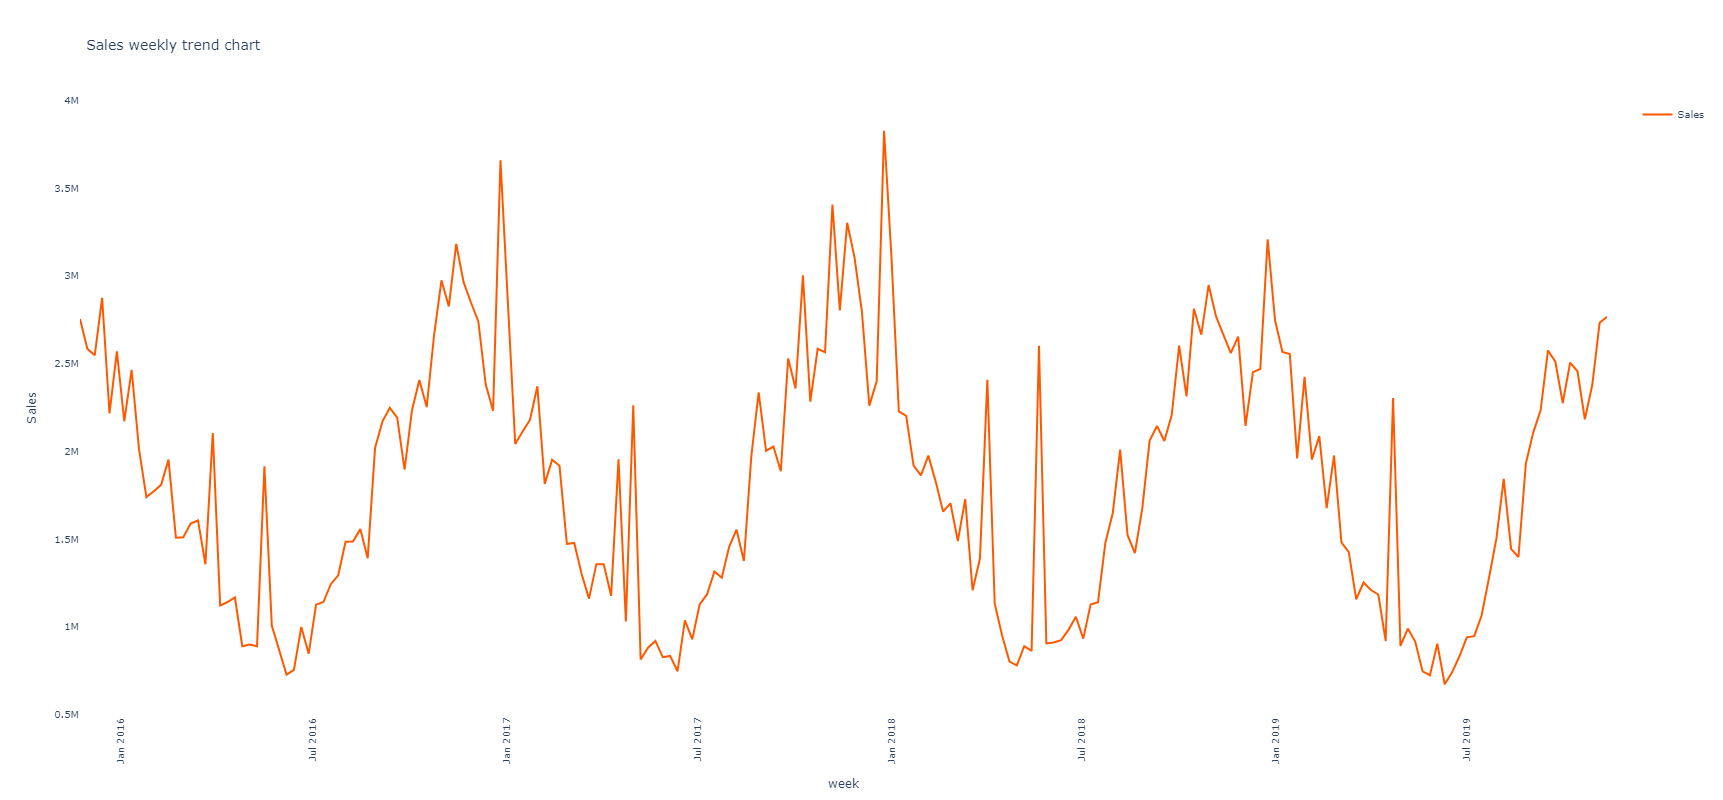

In [338]:
## Check the sales trends using lineplot 

fig1 = go.Figure()


fig1.add_trace(go.Scatter(x=df_model["ds"]
                          , y=df_model["y"]
                          , mode = 'lines'
                          , name = 'Sales'
                          , line=dict(color='rgb(255,89,0)')))

# Update layout with labels and title
fig1.update_layout(title = "Sales weekly trend chart",
                   width = 1200,
                   height = 800,
                   showlegend = True,
                   font = dict(size = 10),
                   xaxis=dict(title="week",tickangle=270),
                   yaxis =dict(title='Sales'),
                   paper_bgcolor='rgba(255,255,255, 1)',
                   plot_bgcolor='rgba(255,255,255, 1)',
                  )

# Show the plot
fig1.show()

**Prophet - Quick Introduction**

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

If you are new to using Prophet, [here](https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet) is a good tutorial to understand all the functionalities 

**Advantages**
1. *Flexible Trend Modeling*
> Changepoints:* Allows for modeling trends that evolve over time by introducing changepoints
> 
> Logistic Growth: Can capture trends that saturate or plateau, such as market saturation or resource constraints

2. *Robust Seasonality Handling*
> Fourier Series: Uses Fourier series to model yearly and weekly seasonality, providing a flexible representation of periodic patterns

3. *Holiday and External Factors*
> Holiday Effects: Can explicitly model the impact of holidays on the time series
> 
> Additional Regressors: Allows for the inclusion of external factors or events, such as new product launches or economic indicators, that may influence the forecast









In [36]:
prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=holidays_weekly)
prophet.add_regressor(name = "events_event1")
prophet.add_regressor(name = "events_event2")

In [38]:
prophet.fit(df_model)
prophet_predict = prophet.predict(df_model)

08:29:07 - cmdstanpy - INFO - Chain [1] start processing
08:29:07 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
prophet_predict.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2015-11-23 2505035.2896 2530473.9222 3117532.0577 2505035.2896 2505035.2896   
1 2015-11-30 2505659.9335 2369436.3888 2975927.8317 2505659.9335 2505659.9335   
2 2015-12-07 2506284.5773 2164305.5472 2783064.6754 2506284.5773 2506284.5773   
3 2015-12-14 2506909.2212 2083902.4766 2703286.6009 2506909.2212 2506909.2212   
4 2015-12-21 2507533.8651 2525265.0129 3126478.7135 2507533.8651 2507533.8651   

   Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0         0.0000               0.0000               0.0000   
1         0.0000               0.0000               0.0000   
2         0.0000               0.0000               0.0000   
3         0.0000               0.0000               0.0000   
4    366296.7260          366296.7260          366296.7260   

   Christmas Day (Observed)  ...       weekly  weekly_lower  weekly_upper  \
0                    0.0000  ... -738657.8681  -738657.8681  -738657.8681   
1                    0.0000  ... -738657.8681  -738657.8681  -738657.8681   
2                    0.0000  ... -738657.8681  -738657.8681  -738657.8681   
3                    0.0000  ... -738657.8681  -738657.8681  -738657.8681   
4                    0.0000  ... -738657.8681  -738657.8681  -738657.8681   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0 1155698.2071  1155698.2071  1155698.2071                0.0000   
1  915602.2529   915602.2529   915602.2529                0.0000   
2  693942.7529   693942.7529   693942.7529                0.0000   
3  623181.9486   623181.9486   623181.9486                0.0000   
4  687020.9969   687020.9969   687020.9969                0.0000   

   multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                      0.0000                      0.0000 2828522.2366  
1                      0.0000                      0.0000 2682604.3183  
2                      0.0000                      0.0000 2461569.4622  
3                      0.0000                      0.0000 2391433.3017  
4                      0.0000                      0.0000 2822193.7200  

[5 rows x 76 columns]

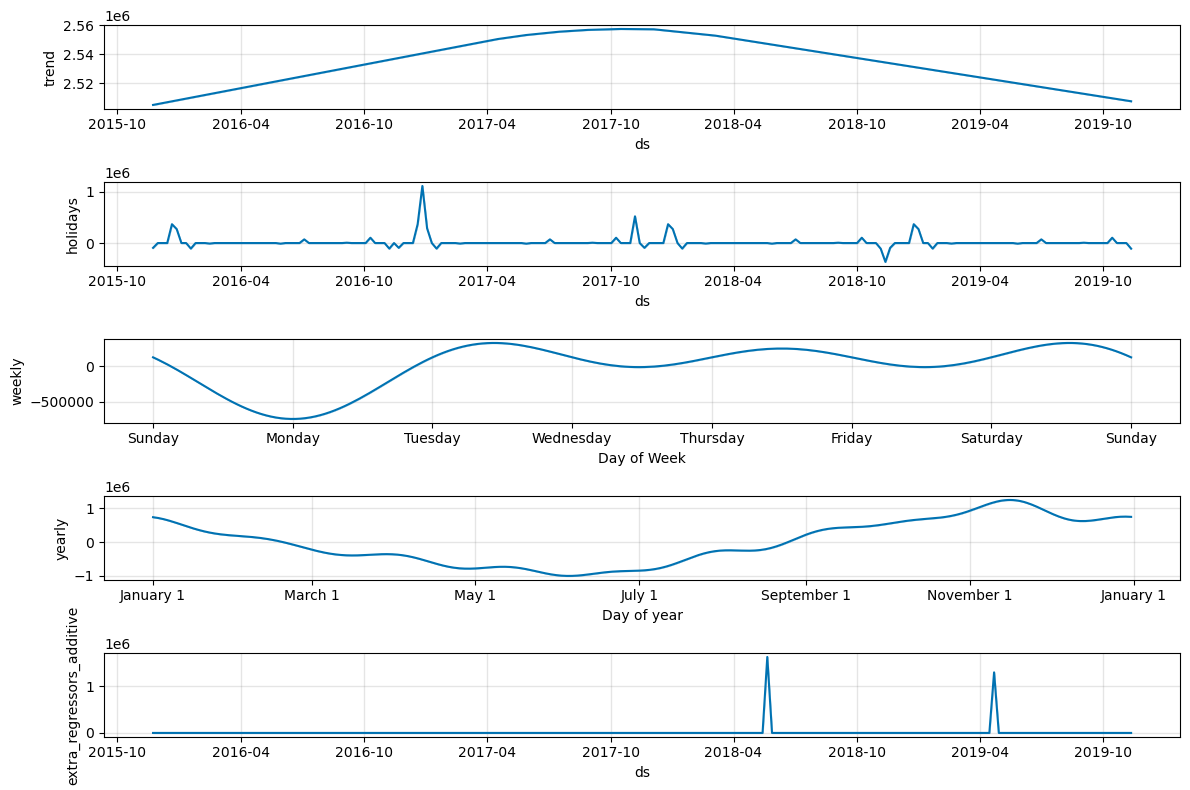

In [42]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    plot = prophet.plot_components(prophet_predict, figsize = (12, 8))

In [43]:
prophet_columns = [col for col in prophet_predict.columns if not col.endswith(("upper", "lower"))]
events_numeric = prophet_predict[prophet_columns].filter(like = "events_").sum(axis = 1)

df_model["trend"] = prophet_predict["trend"]
df_model["season_y"] = prophet_predict["yearly"]
df_model["season_w"] = prophet_predict["weekly"]
df_model["holiday"] = prophet_predict["holidays"]
df_model["events"] = events_numeric.to_numpy()

**Observations**
* `Trend` seems to be increasing from 2015 through 2017 and then starts to decline until 2019
* `Holiday` spikes happen mostly during Holiday period in Q4
*  Sales shows high seasonality during Nov, Dec, Jan period and low seasonality during May, June and July
*  At a weekly level, Sales show low seasonality during Mondays
* `Events` dummy variable capture one-off spike in sales 


## Check Correlations

#### Choice of Media variables
In a MMM study, we typically want to model the impact of marketing on key performance indicators (KPIs). Modeler has to choose between modeling impressions, clicks, or spend variables. To keep things simple and easy, I choose spend as the modeling variable. However, one needs to understand the tradeoff in real life situations

**Advantages**
1. Marketers have direct control over how much to spend in contrast to impressions or clicks
2. If the study is focused on understanding marketing carryover effect, diminishing returns and ROI of media channels, modeling spend directly is an easy way to outcome.

**Disadvantages**
1. If the study is also interested in understanding the effectiveness of media channel (incremental sales per 1000 impressions or 1000 clicks), then modeling spend is not a great choice
2. Spend won't be able to fully capture channel specific dynamics. For example, Video ads might have a higher reach than display ads for the same spend. Or Facebook might have higher click through rate than some other social media channel. 

In [369]:
# Consider 2 years of data for modeling

df_model_2 = df_model.iloc[-104:].copy()

# Add a new column named 'period' filled with 'ptm'
df_model_2['period'] = 'ptm'

# Update the last 52 records in 'period' to 'ttm'
df_model_2.iloc[-52:, df_model_2.columns.get_loc('period')] = 'ttm'

In [371]:
kpi = "y"
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"]
organic_channels = ["newsletter"]
features = ["trend", "season_y", "season_w", "holiday", "competitor_sales_B", "events"] + media_channels + organic_channels

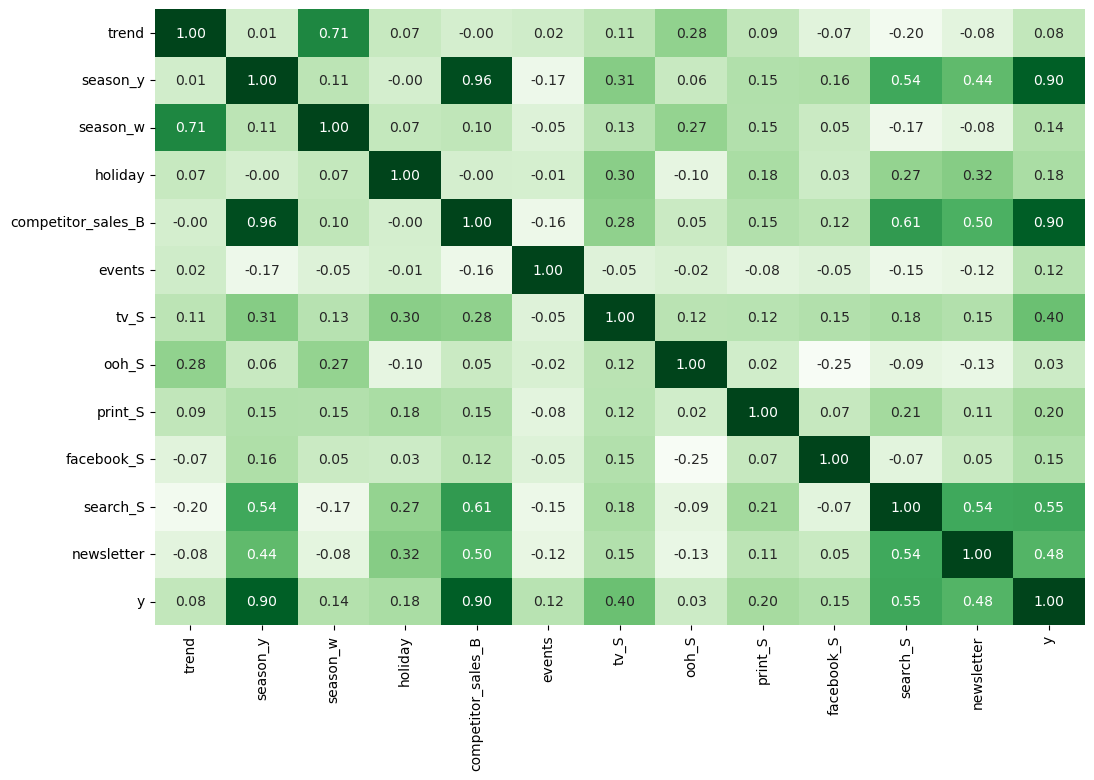

In [373]:
corr = df_model_2[features + [kpi]].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="Greens",annot=True, fmt=".2f", cbar = False);

###### Update with Plotly curves later on

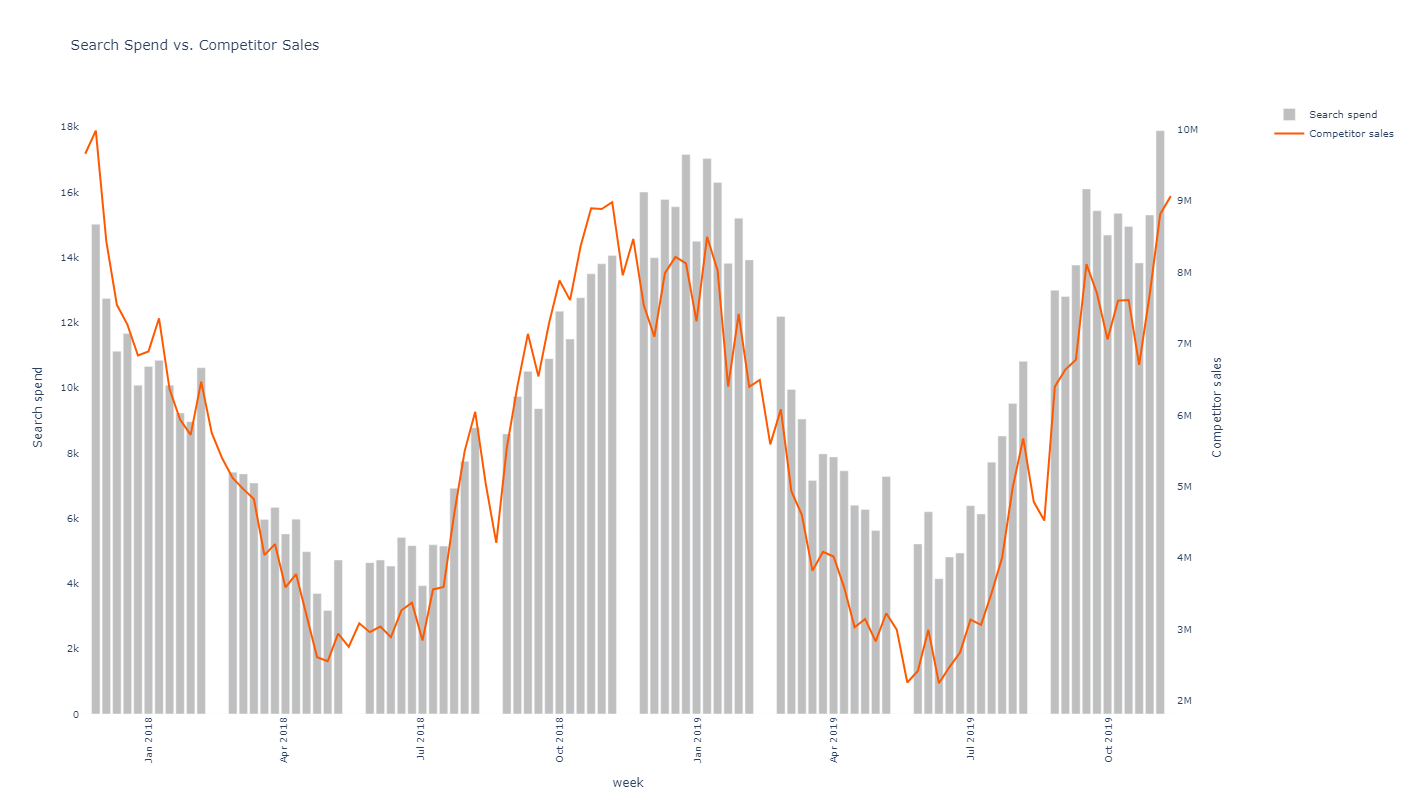

In [376]:
fig1 = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig1.add_trace(go.Bar(x=df_model_2["ds"], 
                      y=df_model_2["search_S"], 
                      marker_color = 'grey',
                      opacity = 0.5, 
                      name = 'Search spend'),secondary_y=False,)

fig1.add_trace(go.Scatter(x=df_model_2["ds"]
                          , y=df_model_2["competitor_sales_B"]
                          , mode = 'lines'
                          , name = 'Competitor sales'
                          , line=dict(color='rgb(255,89,0)')), secondary_y=True,)

# Update layout with labels and title
fig1.update_layout(title = "Search Spend vs. Competitor Sales",
                   width = 1200,
                   height = 800,
                   showlegend = True,
                   font = dict(size = 10),
                   xaxis=dict(title="week",tickangle=270),
                   yaxis1 =dict(title='Search spend'),
                   yaxis2 =dict(title='Competitor sales'),
                   paper_bgcolor='rgba(255,255,255, 1)',
                   plot_bgcolor='rgba(255,255,255, 1)',
                  )

# Show the plot
fig1.show()

**Observations**
* `Trend` is highly correlated with `weekly seasonality`. Let's exclude weekly seasonality from the modeling
* `Yearly seasonality` is highly correlated with both sales and competitor sales
*  Among the paid media channels, `search_S` and `tv_S`show the highest correlation
* `newsletter`, organic media channel also shows high correlation with sales
* `Search_S` and `Competitor_sales` have high correlation. Additionally, Competitor sales have 90% correlation with our target variable. In real life situations, it is hard to get hold of competitor sales data too. So let's exclude competitor sales from the modeling

In [379]:
features = ["trend", "season_y", "holiday", "events"] + media_channels + organic_channels

## Adstock (Carryover effect) transformation

Geometric Adstock is a mathematical model used to represent the carryover effect of past marketing activities on current outcomes. It assumes that the impact of a marketing activity decays exponentially over time. This means that the effect of a past activity diminishes gradually but never completely disappears.

**Why is this transformation required?**

* `Carryover Effect:` Many marketing activities, such as advertising campaigns, have a lasting impact. For example, a successful TV commercial might continue to influence sales even after it stops airing. Adstock models capture this carryover effect. Such delayed impact is not captured by Random Forest algorithm even though it captures the non-linear relationship (saturation).


**Advantages of Geometric Adstock:**

* `Simplicity:` The geometric adstock model is relatively simple to implement and understand.
* `Flexibility:` It can be adapted to various marketing scenarios by adjusting the decay rate parameter.
* `Interpretability:` The model's parameters can be interpreted in terms of the decay rate of the carryover effect.
    
Mathematical Form:

The geometric adstock transformation can be expressed as follows:

$y_t = x_t + alpha * y_{t-1}$

where:

y_t is the adstock effect at time t

x_t is the current ad spend at time t

y(t-1) is the cumulative adstock effect at time t-1

alpha is the decay rate parameter (0 < alpha < 1) 

For example, if we invest 100USD in week1 with alpha set to 0.50, it means we expect the carryover effect to be 50USD in week2, 25USD in week3 and so on. Let's visualize a sample adstock effect below

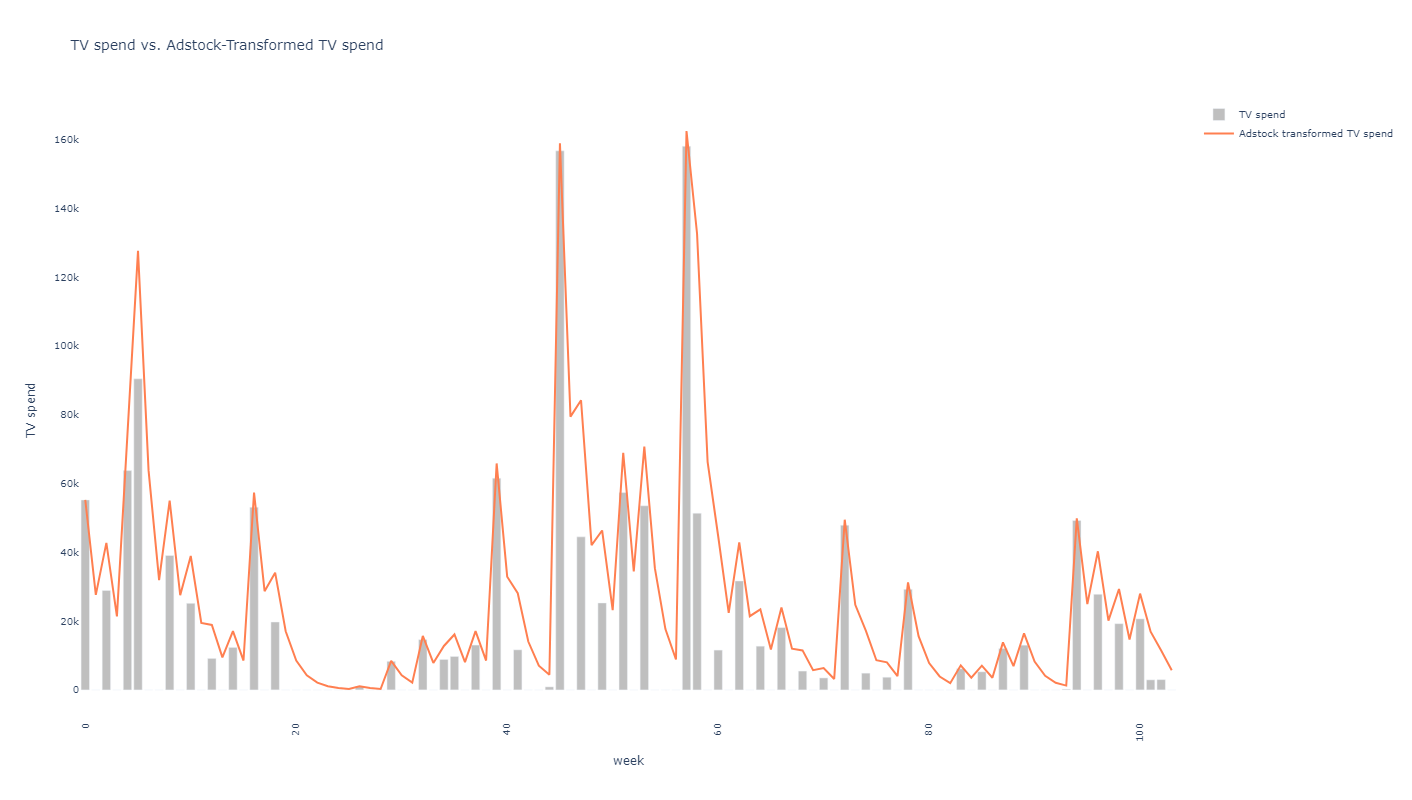

In [383]:
# Example to show how adstock works with 50% decay rate

x = df_model_2.tv_S.values.reshape(-1,1)
adstock = AdstockGeometric(alpha=0.5)
adstock_x = adstock.fit_transform(x)

# Create a DataFrame for easier plotting
adstock_sample = pd.DataFrame({'x': x.flatten(), 'adstock_x': adstock_x.flatten()})

fig1 = go.Figure()

fig1.add_trace(go.Bar(x=adstock_sample.index, 
                      y=adstock_sample["x"], 
                      marker_color = 'grey',
                      opacity = 0.5, 
                      name = 'TV spend'),)

fig1.add_trace(go.Scatter(x=adstock_sample.index
                          , y=adstock_sample["adstock_x"]
                          , mode = 'lines'
                          , name = 'Adstock transformed TV spend'
                          , line=dict(color='coral')))

# Update layout with labels and title
fig1.update_layout(title = "TV spend vs. Adstock-Transformed TV spend",
                   width = 1200,
                   height = 800,
                   showlegend = True,
                   font = dict(size = 10),
                   xaxis=dict(title="week",tickangle=270),
                   yaxis =dict(title='TV spend'),
                   paper_bgcolor='rgba(255,255,255, 1)',
                   plot_bgcolor='rgba(255,255,255, 1)',
                  )

# Show the plot
fig1.show()

## Model building & Hyperparameter Tuning with Optuna

**Optuna**

Optuna is a Python library used for hyperparameter optimization. It provides a framework for automatically searching for the optimal set of hyperparameters for a given machine-learning model. 
Unlike traditional GridSearch, RandomSearch and evolutionary algorithms, Optuna learns from its initial iterations and builds a surrogate model to predict how our loss is expected to evolve when we change our hyperparameters. Optuna also defines an acquisition function to help choose the next hyperparameters to be tried. This acquisition function balances exploitation (rely on the current best) and exploration (keep exploring better possibilities) of the search space. This makes it super efficient while maintaining scalability. [Here](https://optuna.org/) you can find the official page.

**Hyperparameters**

Hyperparameters are settings that you specify before training a machine learning model. They control the behavior of the model and can significantly impact its performance. In our project we have decay rate for adstocking process and n_estimators, max_depth, max_features, etc. for Random Forest algorithm. 

**Why Tune Hyperparameters:**

- *Improved Performance:* Optimizing hyperparameters can lead to better model accuracy, generalization, and overall performance.
- *Avoid Overfitting or Underfitting:* Tuning can help prevent the model from overfitting (memorizing the training data) or underfitting (failing to capture the underlying patterns).
- *Customization:* Hyperparameters allow you to tailor the model to your specific problem and data.

**Steps Involved in Optuna:**

1. Define Objective Function: Create a function that takes hyperparameters as input and returns a metric to be optimized (e.g., squared_error).
2. Define Hyperparameter Search Space: Use trial.suggest_* methods (e.g., suggest_uniform, suggest_int) to define the range of possible values for each hyperparameter.
3. Create Study: Use optuna.create_study() to initialize an optimization study. Specify the optimization direction (minimize or maximize) and the sampling method (e.g., TPE, CMA-ES).
4. Run Optimization: Call study.optimize() to run the optimization process. Optuna will iteratively suggest hyperparameter combinations and evaluate their performance using your objective function.
5. Retrieve Best Parameters: Access the best hyperparameters found during the optimization process using study.best_params.

**Cross Validation with TimeSeriesSplit**

TimeSeriesSplit is an extension of k-fold cross-validation tailored for time series data. Instead of randomly shuffling the data, as in traditional k-fold, TimeSeriesSplit maintains the temporal order. The dataset is split into multiple consecutive folds, with each fold using past data for training and future data for testing. This mimics the real-world scenario where a model is trained on historical data and evaluated on future data. In our case, we apply time series split and pass on the data as argument to optuna objective function

In [67]:
# Apply Time Series Split
tscv = TimeSeriesSplit(n_splits=3, test_size = 20)

# Initialize adstock decay rate params for each media channel
## Search ads are considered to be less memorable while Video / TV ads are considered to be more memorable
## Based on that understanding, assign min and max decay rates for each media channel
## For this project, we are using the ranges suggested by Facebook's Robyn 

adstock_features_params = {}
adstock_features_params["tv_S_adstock"] = (0.3, 0.8)
adstock_features_params["ooh_S_adstock"] = (0.1, 0.4)
adstock_features_params["print_S_adstock"] = (0.1, 0.4)
adstock_features_params["facebook_S_adstock"] = (0.0, 0.4)
adstock_features_params["search_S_adstock"] = (0.0, 0.3)
adstock_features_params["newsletter_adstock"] = (0.1, 0.4)

OPTUNA_TRIALS = 1000
experiment = optuna_optimize(trials = OPTUNA_TRIALS, 
                             data = df_model_2, 
                             target = kpi, 
                             features = features, 
                             adstock_features = media_channels + organic_channels, 
                             adstock_features_params = adstock_features_params, 
                             media_features=media_channels, 
                             tscv = tscv, 
                             is_multiobjective=True) # optimize for both model fit (mape) and business fit (rssd)

data size: 104
media features: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']
adstock features: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
features: ['trend', 'season_y', 'holiday', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
is_multiobjective: True


  0%|          | 0/1000 [00:00<?, ?it/s]

[W 2024-09-20 08:29:21,187] Trial 0 failed with parameters: {'adstock_alpha_tv_S': 0.48727005942368123, 'adstock_alpha_ooh_S': 0.38521429192297485, 'adstock_alpha_print_S': 0.31959818254342154, 'adstock_alpha_facebook_S': 0.23946339367881464, 'adstock_alpha_search_S': 0.04680559213273095, 'adstock_alpha_newsletter': 0.1467983561008608, 'n_estimators': 10, 'min_samples_leaf': 18, 'min_samples_split': 13, 'max_depth': 6, 'ccp_alpha': 0.006175348288740734, 'bootstrap': False, 'criterion': 'squared_error'} because of the following error: The value nan is not acceptable.
[W 2024-09-20 08:29:21,188] Trial 0 failed with value (0.22654704681402085, nan).
[W 2024-09-20 08:29:21,398] Trial 2 failed with parameters: {'adstock_alpha_tv_S': 0.39983689107917986, 'adstock_alpha_ooh_S': 0.2542703315240835, 'adstock_alpha_print_S': 0.2777243706586128, 'adstock_alpha_facebook_S': 0.01858016508799909, 'adstock_alpha_search_S': 0.1822634555704315, 'adstock_alpha_newsletter': 0.15115723710618748, 'n_estima

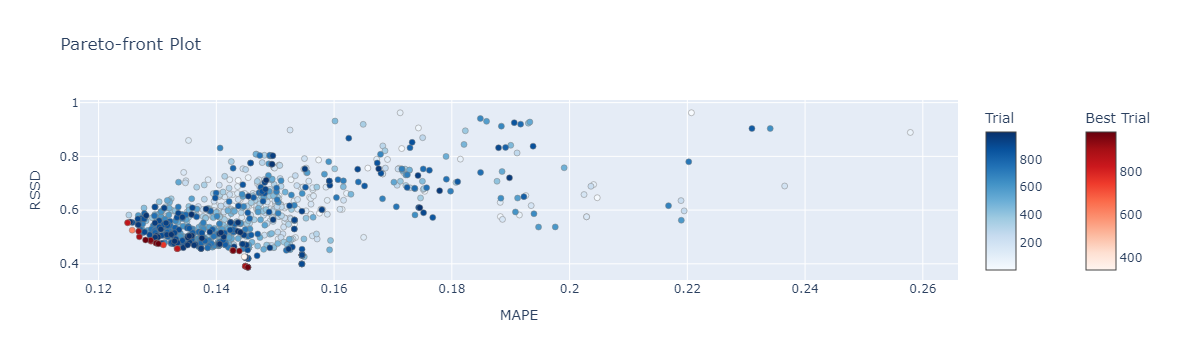

In [69]:
opt.visualization.plot_pareto_front(experiment, target_names=["MAPE", "RSSD"])

In [71]:
print(f"Number of trials on the Pareto front: {len(experiment.best_trials)}")

selected_trial = min(experiment.best_trials, key=lambda t: ((0.3 * t.values[0]) + (0.7 * t.values[1])) )
print("selected: ")
print(f"\tnumber: {selected_trial.number}")
print(f"\tparams: {selected_trial.params}")
print(f"\tvalues: {selected_trial.values}")

Number of trials on the Pareto front: 26
selected: 
	number: 973
	params: {'adstock_alpha_tv_S': 0.3585335082138029, 'adstock_alpha_ooh_S': 0.3491858223363188, 'adstock_alpha_print_S': 0.1458577417552996, 'adstock_alpha_facebook_S': 0.0679031620350163, 'adstock_alpha_search_S': 0.2700069370194033, 'adstock_alpha_newsletter': 0.3612249703817535, 'n_estimators': 29, 'min_samples_leaf': 8, 'min_samples_split': 6, 'max_depth': 6, 'ccp_alpha': 0.15175580788554868, 'bootstrap': False, 'criterion': 'squared_error'}
	values: [0.14535134862535534, 0.3872219371109244]


In [73]:
# Number of best trials
print(f'Number of successfull trials : {len([t for t in experiment.trials if t.state == opt.trial.TrialState.COMPLETE])}')
print(f'Number of best trials : {len(experiment.best_trials)}')

Number of successfull trials : 912
Number of best trials : 26


In [75]:
print(f'MAPE from best trials : {np.mean(experiment.best_trials[0].user_attrs["scores"]) *100:.2f}%')

MAPE from best trials : 14.47%


In [79]:
for i, trial in enumerate(experiment.best_trials):
    if trial.number == selected_trial.number:
        trial_index = i
        break

In [81]:
experiment.best_trials[trial_index].user_attrs["params"]

{'n_estimators': 29,
 'min_samples_leaf': 8,
 'min_samples_split': 6,
 'max_depth': 6,
 'ccp_alpha': 0.15175580788554868,
 'bootstrap': False,
 'criterion': 'squared_error'}

In [83]:
experiment.best_trials[trial_index].user_attrs["adstock_alphas"]

{'tv_S': 0.3585335082138029,
 'ooh_S': 0.3491858223363188,
 'print_S': 0.1458577417552996,
 'facebook_S': 0.0679031620350163,
 'search_S': 0.2700069370194033,
 'newsletter': 0.3612249703817535}

In [85]:

# Get the best trials
best_trials = experiment.best_trials

# Initialize a dictionary to store parameter averages
param_averages = {}
adstock_averages = {}
final_params = {}
final_adstock = {}
metric_averages = {}
final_metric = {}


# Iterate through the best trials and extract parameters
for trial in best_trials:
    params = trial.user_attrs["params"]
    for param_name, param_value in params.items():
        if param_name not in param_averages:
            param_averages[param_name] = []
        param_averages[param_name].append(param_value)
        
    adstock_alphas = trial.user_attrs["adstock_alphas"]
    for adstock_name, adstock_value in adstock_alphas.items():
        if adstock_name not in adstock_averages:
            adstock_averages[adstock_name] = []
        adstock_averages[adstock_name].append(adstock_value)

    trial_values = trial.values
    if 'MAPE' not in metric_averages:
            metric_averages['MAPE'] = []
    metric_averages['MAPE'].append(trial_values[0])
    
    if 'RSSD' not in metric_averages:
            metric_averages['RSSD'] = []
    metric_averages['RSSD'].append(trial_values[1])


# Calculate the average for each parameter
for param_name, values in param_averages.items():
    if isinstance(values, int) or isinstance(values, float):
        average_value = sum(values) / len(values)
        final_params[param_name] = average_value
    else:
        final_params[param_name] = max(set(values), key=values.count)
    
    
# Calculate the average for each adstock decay rate
for adstock_name, values in adstock_averages.items():
    average_value = sum(values) / len(values)
    final_adstock[adstock_name] = average_value

# Calculate the average for fit metrics
for metric_name, values in metric_averages.items():
    average_value = sum(values)/len(values)
    final_metric[metric_name] = average_value

print(final_params)
print(final_adstock)
print(final_metric)


{'n_estimators': 16, 'min_samples_leaf': 3, 'min_samples_split': 10, 'max_depth': 6, 'ccp_alpha': 0.22106212348325463, 'bootstrap': True, 'criterion': 'squared_error'}
{'tv_S': 0.6838494982490241, 'ooh_S': 0.28992322875206233, 'print_S': 0.2175469947306303, 'facebook_S': 0.27826920348744416, 'search_S': 0.15585657556109328, 'newsletter': 0.33966577704842754}
{'MAPE': 0.1346924627796332, 'RSSD': 0.46596344840723}


**Observations**
* `Optuna` helped us run 1000 trials, where 912 trials completed successfully optimizing for both minimum MAPE (model fit) and minimum RSSD (business fit). The RSSD, decomposition distance accounts for a relationship between spend share and a channel’s coefficient decomposition share. If the distance is too far, its result can be too unrealistic - e.g. media activity with the smallest spending gets the largest effect.
* `Optuna` picked 26 best trials based on the pareto plot. These trials are the ones close to solve our multi-objective optimization. We can pick the parameters of one the best trials based on some business rules (eg., more importance to business fit vs model fit) or we can average the parameters across all the 26 best trials. I chose the latter since it makes sense to decide based on multiple best trials instead of arbitrarily defining a champion model. This is a subjective call.  

## Model Refit using the best parameters

In [212]:
best_params = final_params
adstock_params = final_adstock
result = model_refit(data = df_model_2, 
                     target = kpi,
                     features = features, 
                     media_channels = media_channels, 
                     organic_channels = organic_channels, 
                     model_params = best_params, 
                     adstock_params = adstock_params
                    )

applying geometric adstock transformation on tv_S with alpha 0.6838494982490241
applying geometric adstock transformation on ooh_S with alpha 0.28992322875206233
applying geometric adstock transformation on print_S with alpha 0.2175469947306303
applying geometric adstock transformation on facebook_S with alpha 0.27826920348744416
applying geometric adstock transformation on search_S with alpha 0.15585657556109328
applying geometric adstock transformation on newsletter with alpha 0.33966577704842754
predicting 104


In [823]:
# Save necessary outputs for Streamlit deployment

df_model_2.to_parquet('./output/df_model_2.parquet')

result['df_shap_values'].to_parquet('./output/df_shap_values.parquet')

result['x_input_interval_nontransformed'].to_parquet('./output/x_input_interval_nontransformed.parquet')

result['x_input_interval_transformed'].to_parquet('./output/x_input_interval_transformed.parquet')

prediction_interval = result['prediction_interval']
np.save('./output/prediction_interval.npy', prediction_interval)

y_true_interval = result['y_true_interval']
np.save('./output/y_true_interval.npy', y_true_interval)

media_channels_array = np.array(media_channels)
np.save('./output/media_channels_array.npy', media_channels_array)

with open('./output/final_adstock.json', 'w') as f:
    json.dump(final_adstock, f)

## Analyze the Model Results

MAPE: 8.45%
R2: 89.43%


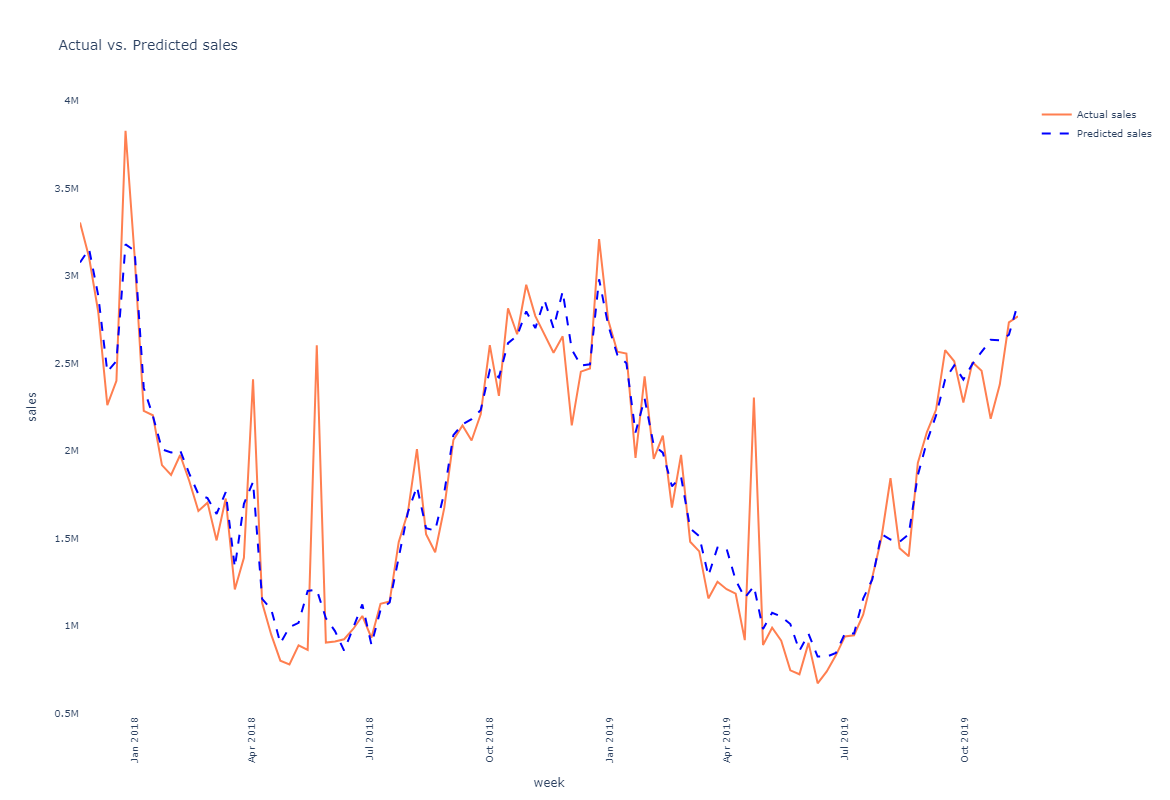

In [456]:
mape_metric = mean_absolute_percentage_error(y_true = result["y_true_interval"], y_pred = result["prediction_interval"])
r2_metric = r2_score(y_true = result["y_true_interval"], y_pred = result["prediction_interval"])

print(f'MAPE: {mape_metric*100:.2f}%')
print(f'R2: {r2_metric*100:.2f}%')

chart_data = pd.DataFrame({'week' : df_model_2.ds.to_numpy(),
                           'actual_sales' : result["y_true_interval"],
                           'predicted_sales' : result["prediction_interval"]
                          })

chart_data['error'] = chart_data['actual_sales'] - chart_data['predicted_sales']

fig1 = go.Figure()

fig1.add_trace(go.Scatter(x=chart_data.week
                          , y=chart_data["actual_sales"]
                          , mode = 'lines'
                          , name = 'Actual sales'
                          , line=dict(color='coral')))

fig1.add_trace(go.Scatter(x=chart_data.week
                          , y=chart_data["predicted_sales"]
                          , mode = 'lines'
                          , name = 'Predicted sales'
                          , line=dict(color='blue', dash = 'dash')))


# Update layout with labels and title
fig1.update_layout(title = "Actual vs. Predicted sales",
                   width = 1200,
                   height = 800,
                   showlegend = True,
                   font = dict(size = 10),
                   xaxis=dict(title="week",tickangle=270),
                   yaxis =dict(title='sales'),
                   paper_bgcolor='rgba(255,255,255, 1)',
                   plot_bgcolor='rgba(255,255,255, 1)',
                  )

# Show the plot
fig1.show()

## Media Contribution

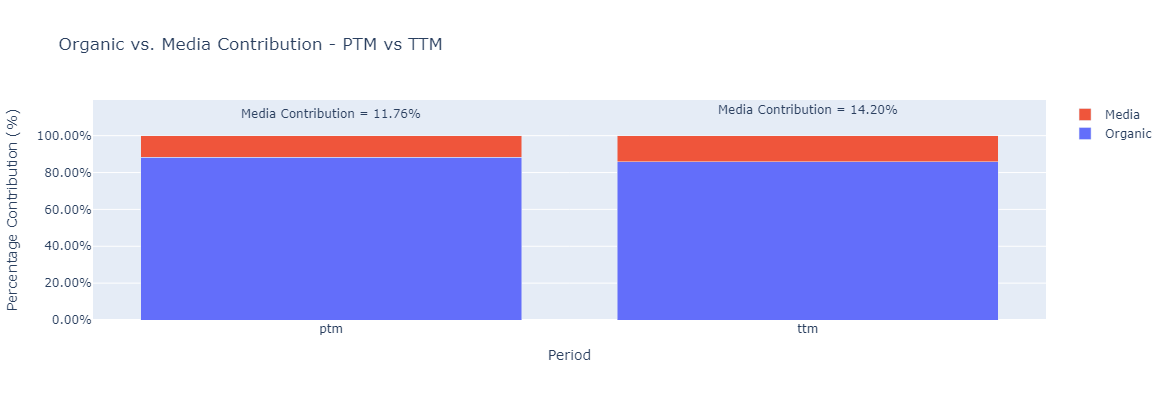

In [664]:
## Media Contribution 
df_shap_values2 = df_shap_values.copy().assign(
    period='ptm',
    shap_organic=lambda df: df.loc[:, organic_features].abs().sum(axis=1),
    shap_media=lambda df: df.loc[:, media_channels].abs().sum(axis=1)
)

df_shap_values2.iloc[-52:, df_shap_values2.columns.get_loc('period')] = 'ttm'

df_shap_agg = df_shap_values2[['period', 'shap_organic', 'shap_media']].copy()
df_shap_agg_period = df_shap_agg.groupby('period').sum().reset_index()

df_shap_agg_period['perc_organic'] = df_shap_agg_period['shap_organic'] / (
    df_shap_agg_period['shap_organic'] + df_shap_agg_period['shap_media']
)
df_shap_agg_period['perc_media'] = df_shap_agg_period['shap_media'] / (
    df_shap_agg_period['shap_organic'] + df_shap_agg_period['shap_media']
)

# Create Plotly bar charts
fig2 = go.Figure()
fig2.add_trace(go.Bar(x=df_shap_agg_period['period'], y=df_shap_agg_period['perc_organic'], name='Organic'))
fig2.add_trace(go.Bar(x=df_shap_agg_period['period'], y=df_shap_agg_period['perc_media'], name='Media'))

# Add text annotations
for i, (organic, media) in enumerate(zip(df_shap_agg_period['perc_organic'], df_shap_agg_period['perc_media'])):
    fig2.add_annotation(
        text=f"Media Contribution = {media*100:.2f}%",
        x=i,  # Adjust x position based on index
        y=media + 1,  # Adjust y position slightly above the bar
        showarrow=False,
        font=dict(size=12)  # Adjust font size as needed
    )

fig2.update_layout(
    title="Organic vs. Media Contribution - PTM vs TTM",
    width = 800,
    height = 400,
    xaxis_title="Period",
    yaxis_title="Percentage Contribution (%)",
    barmode='stack',
    yaxis=dict(tickformat=".2%")
)

## Feature Importance

C:\Users\aruns\Documents\Learning\RandomForest_MMM\RF_MMM\RF_MMM_utils.py:213: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



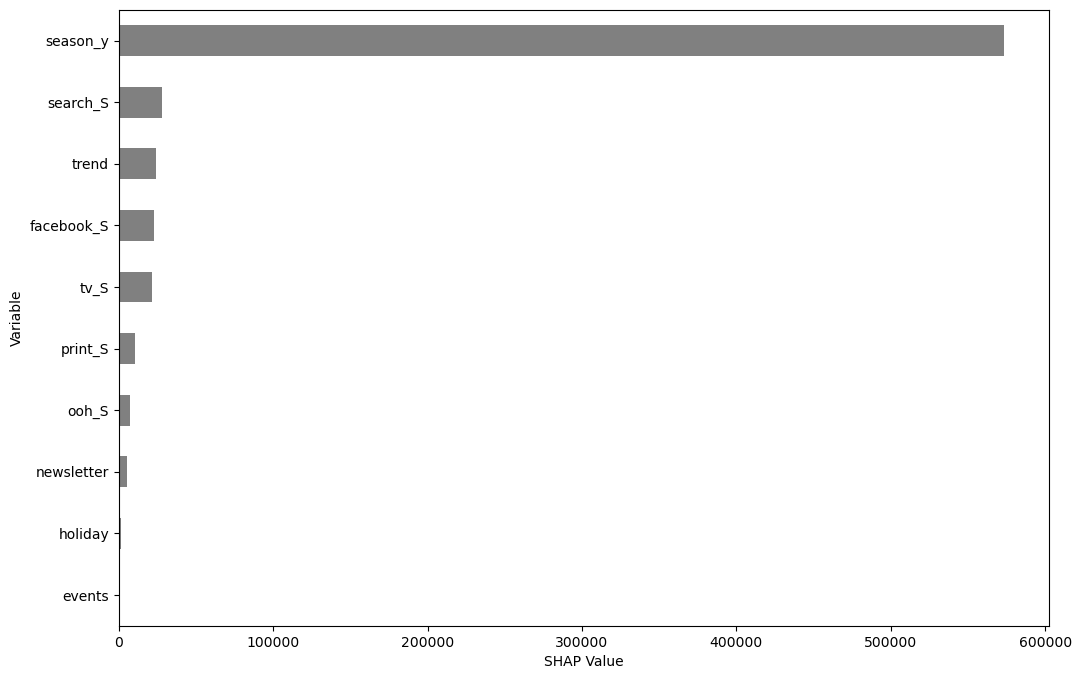

In [634]:
shap_feature_importance(result["df_shap_values"], result["x_input_interval_transformed"])

## Share of Spend vs Share of Effect

DECOMP.RSSD: 0.43809892925862925


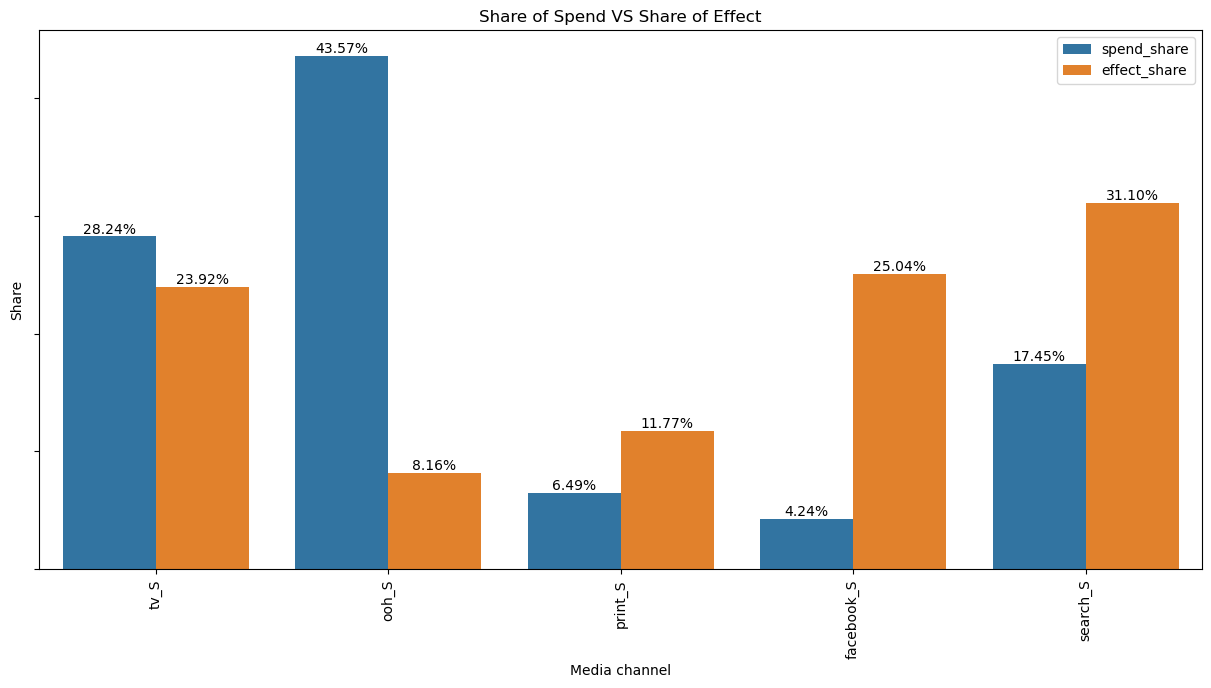

None


In [671]:
spend_effect_share = calculate_spend_effect_share(df_shap_values = result["df_shap_values"]
                                                  , media_channels = media_channels
                                                  , df_original = result["x_input_interval_nontransformed"])

decomp_rssd = rssd(effect_share = spend_effect_share.effect_share.values, spend_share = spend_effect_share.spend_share.values)
print(f"DECOMP.RSSD: {decomp_rssd}")
print(plot_spend_vs_effect_share(spend_effect_share, figure_size = (15, 7)));



## Incremental ROAS

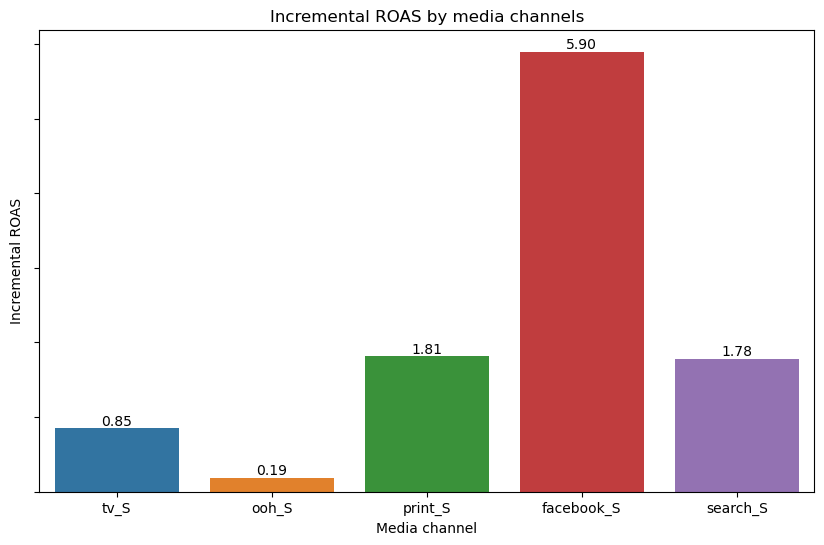

In [630]:
plot_incr_roas(spend_effect_share, (10,6))

## Ad Carryover effect

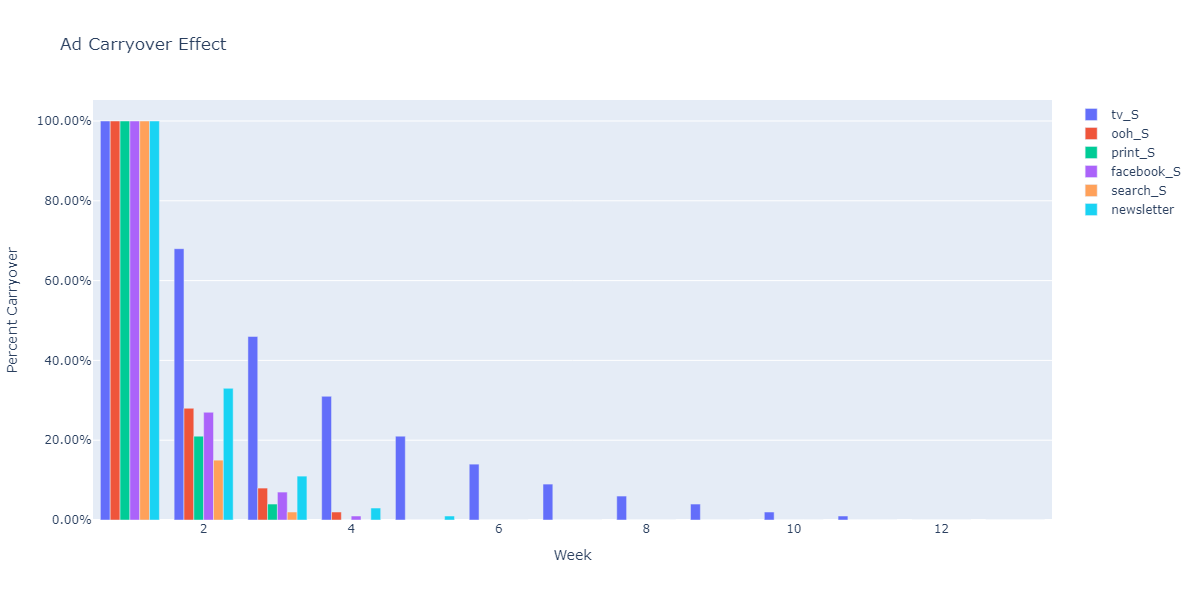

In [828]:
plot_adcarryover_effect(final_adstock)

## Media Response Curves using SHAP values

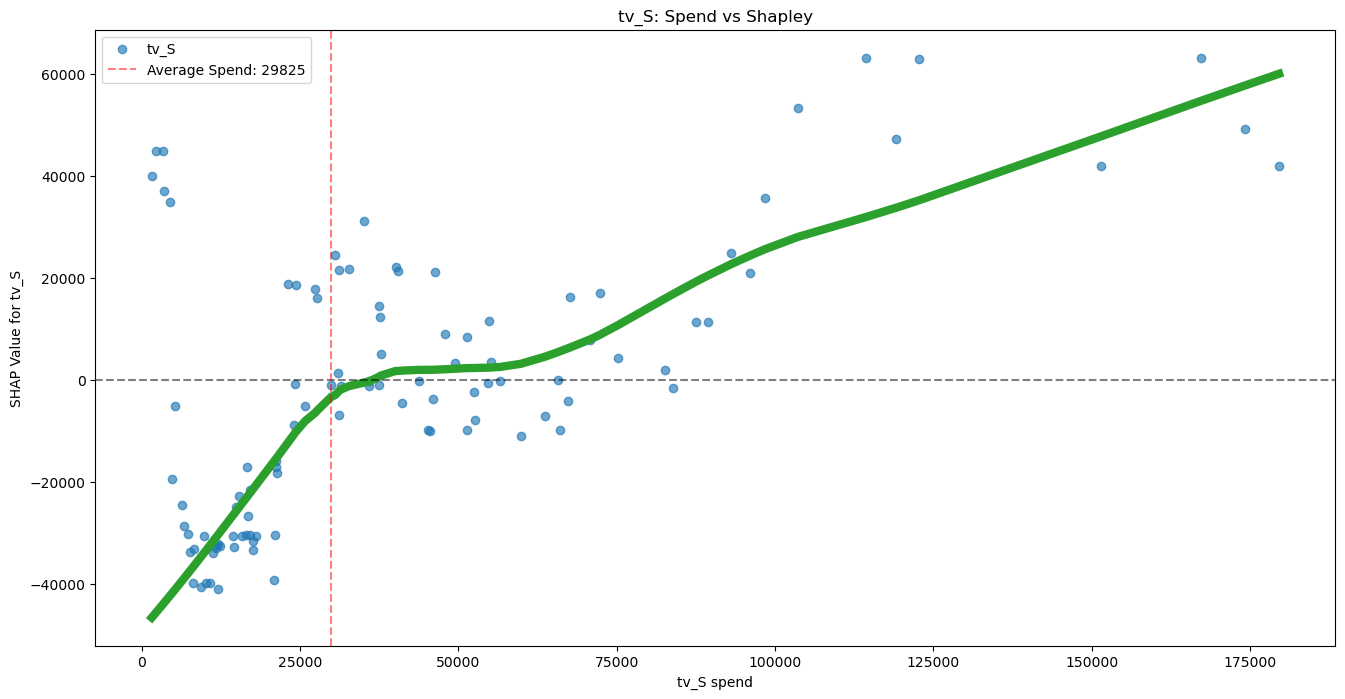

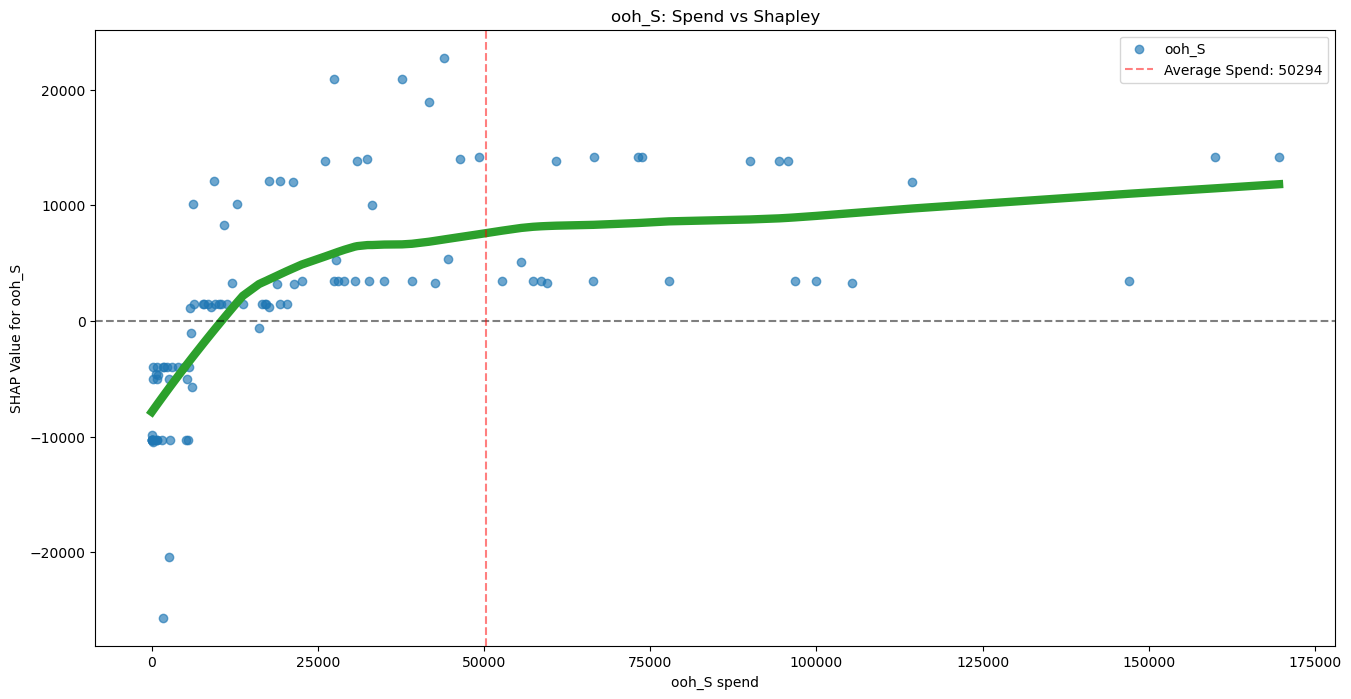

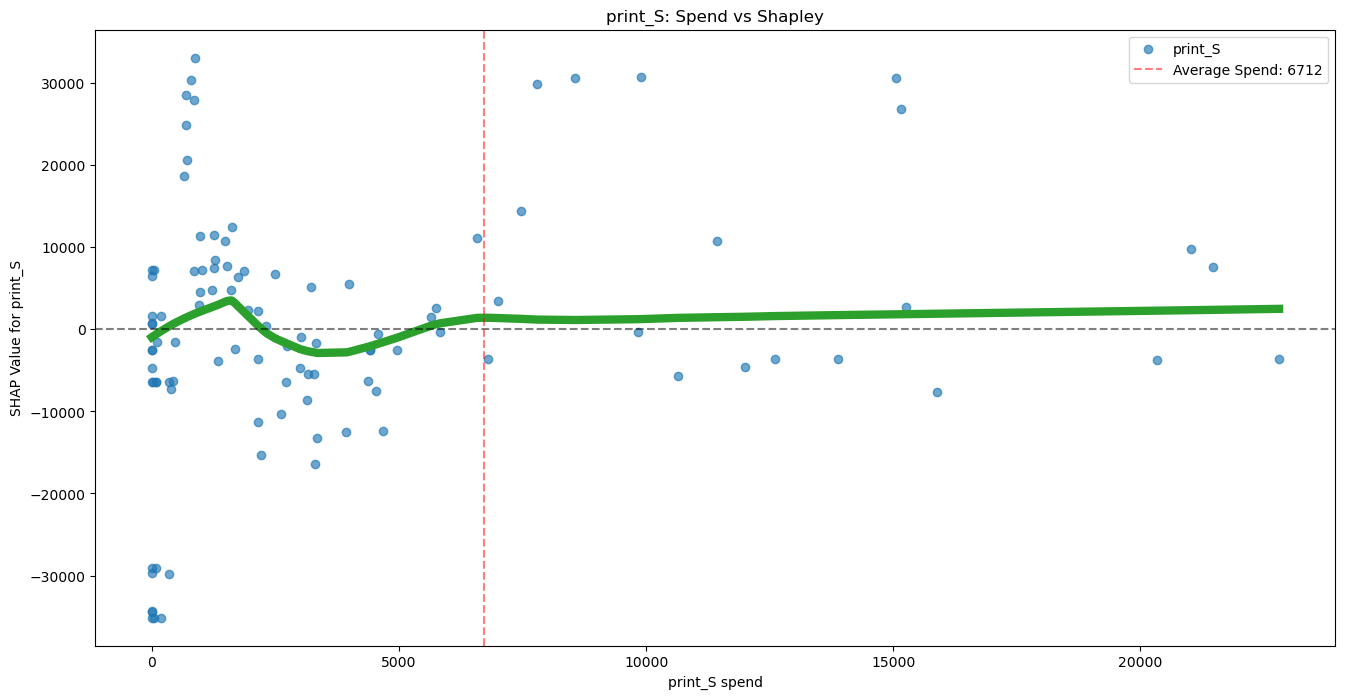

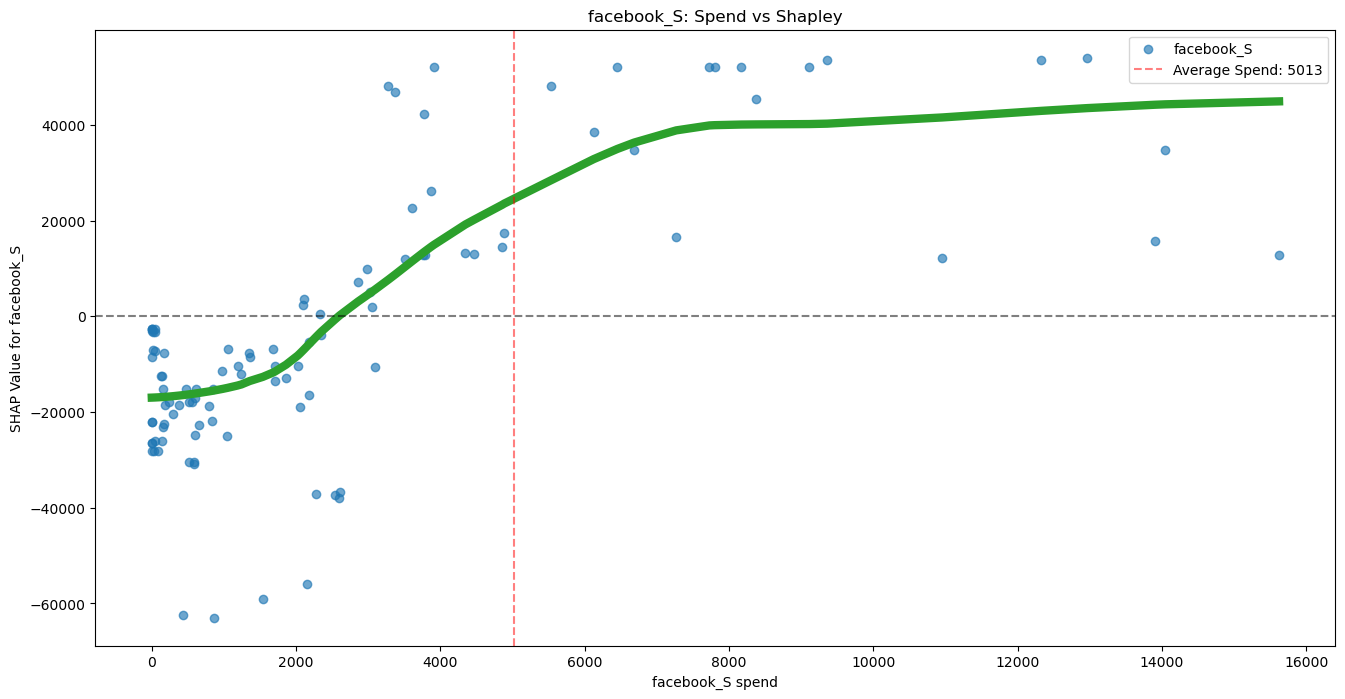

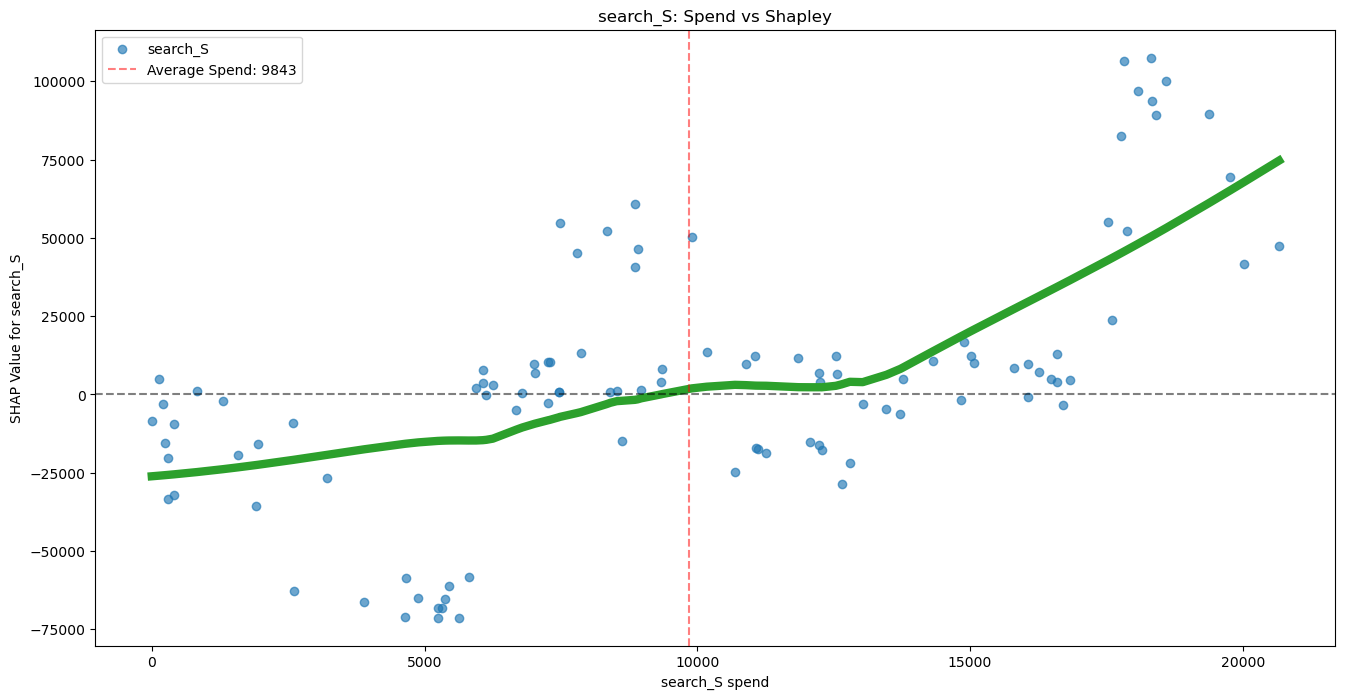

In [675]:
for channel in media_channels:
    plot_shap_vs_spend(result["df_shap_values"], result["x_input_interval_nontransformed"], result["x_input_interval_transformed"], channel)